In [5]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/V_bias/particleData/'
outfolder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_final_WITH_extraction_V_bias/'
files = os.listdir(folder)
files

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/V_bias/particleData/'

In [6]:
def preprocess_COMSOL_sweep(fname, sweep_vals):
    """
    fname: csv file of COMSOL output to read
    sweep_vals: what are the sweep values in a list
    
    Returns a dictionary with the dataframes qx qy qz for each file
    """
    
    # read the data and format the , correctly
    data = pd.read_csv(fname, skiprows=8, index_col=0, nrows=10, delimiter=r'\s+', header=None)
    with open(fname, 'r') as file:
        for line in file:
            if 'Index' in line:
                cols = line.rstrip().split(',')
                break
        file.close()
    col_str = ''.join(cols)
    col_str = col_str.replace('q', ' ,q')
    col_list = col_str.split(',')
    col_list = col_list[1:]

    

    # read the data again, use the columns found before as the headers
    data = pd.read_csv(fname, skiprows=8, index_col=0, header=None, delimiter=r'\s+')
    data.columns = col_list

    # filter the columns
    d_sweep = {}
    # dictionary of the dataframes, each dataframe is a separate sweep value
    dic_dfs = {}
    for val in sweep_vals:
        # find the 
        cols = [c for c in data.columns if val == re.findall(r'=(\S*)', c)[1]]
        d_sweep[val] = cols
    # add each dataframe to a separate place in the dictionary
    for key in d_sweep.keys():
        this_data = data.loc[:,d_sweep[key]]
        # rename the columns in qx, qy, qz
        new_cols = []
        for c in cols:
            if 'qx' in c:
                new_cols.append('qx')
            if 'qy' in c:
                new_cols.append('qy')
            if 'qz' in c:
                new_cols.append('qz')
        this_data.columns = new_cols

        dic_dfs[key] = this_data

    return dic_dfs

In [7]:
def make_plot_KDE(data, outfolder, figname, axis_lim):
    """
    Makes the gaussian kde and the y z plot.
    data is the dataframe with qx, qy, qz as headers and reach row is one sample data with the respecitve positions
    """
    nbins = 200
    lim = axis_lim
    #     print(data[pd.isnull(data).any(axis=1)])
    # save as csv
    data.to_csv(f'{outfolder}/{figname}.csv')
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     print(zi.reshape(xi.shape))
    # plot
    fs = 20

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40])
#     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    plt.savefig(f'{outfolder}/{figname}.pdf')

    plt.show()

    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
#     print(gauss(x0_y, *popt), A_y)

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, 0.30)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
    plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
    plt.text(-0.7, .06, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    plt.ylim(ylims)
    # bottom plot
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
  
    plt.text(-0.3, .06, f'FWHM = {FWHM_y:.2f} mm', fontsize=14)
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.show()

# File 01

In [8]:
ii = 1

sweep_vals = ['0', '0.2', '0.8']

fignames = [f.replace('.txt', '') for f in files]
datafiles = [f"{folder}{f}" for f in files]
print(datafiles )
fname = datafiles[ii]
fname

NameError: name 'files' is not defined

In [9]:
dic_dfs = preprocess_COMSOL_sweep(fname, sweep_vals)
for key in dic_dfs:
    data = dic_dfs[key]
    figname = f"{files[ii]}_{key}"
    make_plot_KDE(data, outfolder, figname, axis_lim=3)

NameError: name 'fname' is not defined

# File 02

In [10]:
ii = 0

sweep_vals = ['1', '1.4', '2']

fignames = [f.replace('.txt', '') for f in files]
datafiles = [f"{folder}{f}" for f in files]
print(datafiles )
fname = datafiles[ii]
fname

NameError: name 'files' is not defined

In [11]:
dic_dfs = preprocess_COMSOL_sweep(fname, sweep_vals)
for key in dic_dfs:
    data = dic_dfs[key]
    figname = f"{files[ii]}_{key}"
    make_plot_KDE(data, outfolder, figname, axis_lim=3)

NameError: name 'fname' is not defined

# Load data and plot FWHM vs extraction

In [12]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
import re


In [13]:
folder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_final_WITH_extraction_V_bias/'
files = [f for f in os.listdir(folder) if f.endswith('csv')]
files

['07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.WITHEXTRACTION_01.txt_0.8.csv',
 '07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.WITHEXTRACTION_01.txt_0.csv',
 '07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.WITHEXTRACTION_02.txt_2.csv',
 '07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.WITHEXTRACTION_02.txt_1.csv',
 '07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.WITHEXTRACTION_02.txt_1.4.csv',
 '07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.WITHEXTRACTION_01.txt_0.2.csv']

In [14]:
bias = [re.findall(r'.txt_(.*?).csv', f)[0] for f in files] # bias in kV
bias = np.asarray(bias, dtype=np.float64)


In [15]:
def get_FWHM(x, k, r, ax):
    """
    Get the FWHMs parallel to the axis: ax
    """
    assert ax in ['x', 'y']
    if ax == 'x':
        y = [k.evaluate([y,r])[0] for y in x]
    else:
        y = [k.evaluate([r,y])[0] for y in x]
    
    if np.max(y) > 1e-4:
        def find_nearest(array, value):

            array = np.asarray(array)
            dis = (np.abs(array - value))
#             if len(dis) < 5:
#                 print(y, array, value)
            idx = dis.argmin()

            return idx, array[idx]

        Y_max = np.max(y)
        Y_max_half = Y_max/2.0
    #     print(Y_max, Y_max_half)
        # x point on positive and side
        idx_0 = find_nearest(x, Y_max)[0]
        idx_pos_max_half = find_nearest(y[idx_0:], Y_max_half)[0]
        idx_neg_max_half = find_nearest(y[:idx_0], Y_max_half)[0]
    #     print(find_nearest(eval_x[idx_0:], Y_max_half))
        # FWHM
        FWHM = x[idx_pos_max_half+idx_0]-x[idx_neg_max_half]

    #     return x[idx_neg_max_half], x[idx_pos_max_half+idx_0], FWHM
        return FWHM
    else:
        return 0

def get_max_FWHMs(data, nbins=400, eval_points=300, lim=4):
    """
    returns the maximum values for the FWHM paralell to x and y direction. X is corresponding to parallel to y, z is parallel to y
    """
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    eval_points 
    qry_eval = np.linspace(-lim,lim,eval_points)

    df = pd.DataFrame({'qry_eval': qry_eval})
    df['FWHM_z'] = df['qry_eval'].apply(lambda r: get_FWHM(qry_eval, k, r, ax='y'))
    df['FWHM_y'] = df['qry_eval'].apply(lambda r: get_FWHM(qry_eval, k, r, ax='x'))
    FWHM_y = np.max(df['FWHM_y'] )
    FWHM_z = np.max(df['FWHM_z'] )
    
    return pd.Series([FWHM_y, FWHM_z], index=['FWHM_y', 'FWHM_z'])

In [16]:
df_fwhm = pd.DataFrame()
for file in files:
    data = pd.read_csv(f"{folder}/{file}")
    s = get_max_FWHMs(data, nbins=400, eval_points=300, lim=4)
    df_fwhm[file] = s

In [17]:
df_fwhm.columns = bias
df_fwhm = df_fwhm.T
df_fwhm = df_fwhm.sort_index()

In [20]:
df_fwhm

,FWHM_y,FWHM_z
0.0,1.846154,2.836120
0.2,1.846154,2.836120
0.8,1.846154,2.836120
1.0,1.846154,2.809365
1.4,1.819398,2.809365
2.0,1.819398,2.809365


In [22]:
OUTFOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_suppression_FWHM_V_Bias/'
FIGNAME = 'COMSOL_suppression_FWHM_V_Bias'
df_fwhm.to_csv(f"{OUTFOLDER}/FWHM_DATA.csv")
# df_fwhm = pd.read_csv(f"{OUTFOLDER}/FWHM_DATA.csv", index_col=0)

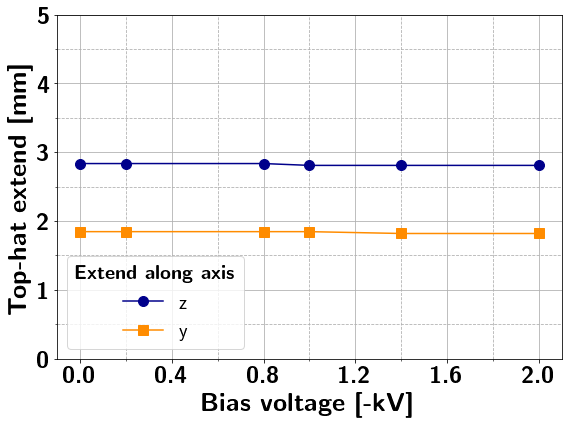

In [23]:
# plot for each time
fig, ax1 = plt.subplots(figsize=(8, 6))
fs = 26


x = df_fwhm.index.values
c = 'darkblue' # color
y = df_fwhm['FWHM_z'].values
ax1.plot(x, y, linestyle='-', marker='o', color=c, markersize=10) # y


x = df_fwhm.index.values
c = 'darkorange' # color
y = df_fwhm['FWHM_y'].values
ax1.plot(x, y, linestyle='-', marker='s', color=c, markersize=10) # y

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='darkblue', label='z',
                          markerfacecolor='darkblue', markersize=10),
                   Line2D([0], [0], marker='s', color='darkorange', label='y',
                          markerfacecolor='darkorange', markersize=10)
                   ]

# l2 = plt.legend(handles=legend_elements,loc=(0.31, 0.81), handlelength=0, fontsize=14)
l2 = plt.legend(handles=legend_elements, loc='lower left', fontsize=fs-6)
l2.set_title(r"\textbf{Extend along axis}", prop = {'size': fs-6})

ax1.set_xlabel(r"\textbf{Bias voltage [-kV]}", fontsize=fs)
ax1.set_ylabel(r"\textbf{Top-hat extend [mm]}", fontsize=fs)

ax1.tick_params(axis='y', labelsize=fs-2)
ax1.tick_params(axis='x', labelsize=fs-2)

# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')


plt.ylim(0, 5)
plt.xlim(-0.1,2.1)
ax1.set_xticks(np.arange(0, 2.2, 0.4))
plt.tight_layout()
plt.savefig(f"{OUTFOLDER}{FIGNAME}.pdf")
plt.show()